In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.transforms import ToUndirected, RemoveIsolatedNodes
from torch_geometric.utils import to_networkx
import networkx
from networkx import set_node_attributes

import os
import json
from bokeh.io import output_notebook, show
from bokeh.models import Range1d, Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.transform import linear_cmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from umap import UMAP
import numpy as np
from typing import List

from dataset import Dataset

/home/sebastiaan/fun/alarso/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sebastiaan/fun/alarso/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sebastiaan/fun/alarso/venv/lib/python3.10/site-packages/umap/distanc

In [2]:
def load_graph(remove_isolated=True, to_undirected=True):
    dataset = Dataset()
    dataset.load("data")

    # Add the embeddings to the nodes
    count = 0
    for node in tqdm(dataset.nodes):
        node[1]["embedding"] = torch.empty((0, 1024))
        if node[0] in os.listdir(f"embeddings/"):
            embedding_paths = [f"embeddings/{node[0]}/{i}" for i in
                               os.listdir(f"embeddings/{node[0]}")]
            for path in embedding_paths:
                with open(path, "r") as f:
                    try:
                        embedding = torch.Tensor(json.load(f))
                        node[1]["embedding"] = torch.cat(
                            (node[1]["embedding"], embedding),
                            dim=0
                        )
                    # Except when the file is empty
                    except json.decoder.JSONDecodeError:
                        pass
        # Take the first 30 embeddings
        node[1]["embedding"] = node[1]["embedding"][:5, :]
        node[1]["embedding"] = torch.nn.ConstantPad2d(
            (0, 0, 5-node[1]["embedding"].shape[0], 0), torch.nan
        )(node[1]["embedding"])
        node[1]["embedding"] = node[1]["embedding"].flatten()

        if node[1]["embedding"].isnan().all():
            dataset.nodes = [i for i in dataset.nodes if i[0] != node[0]]
            dataset.edges = [i for i in dataset.edges if i[0][0] != node[0]]
            dataset.edges = [i for i in dataset.edges if i[0][1] != node[0]]
            count += 1
            continue

        new_x = torch.empty(0, 5*1024)
        emb = node[1]["embedding"]
        emb = emb[emb.isnan()==False]
        n_to_add = 5 - emb.shape[0] // 1024
        while n_to_add > 0:
            print(n_to_add, emb.shape)
            emb = torch.cat((emb, emb), dim=0)
            n_to_add = 5 - emb.shape[0] // 1024
        emb = emb[:5*1024]
        new_x = torch.vstack((new_x, emb))
        node[1]["embedding"] = new_x.squeeze()

    print(f"Proportion of nodes with no embeddings: {count/len(dataset.nodes)}")

    # Remove edges with no ids in the nodes (the data collection was stopped
    # before expansion to these nodes)
    edge_ids = [i[0][0] for i in dataset.edges] + [i[0][1] for i in dataset.edges]
    edge_ids = list(set(edge_ids))
    node_ids = [i[0] for i in dataset.nodes]
    not_in = [i for i in edge_ids if i not in node_ids]
    print("---", len(dataset.edges))
    dataset.edges = [i for i in dataset.edges if i[0][1] not in not_in]
    print("---", len(dataset.edges))

    # Remove disconnceted nodes
    print(">>> Before removing disconnected:", len(dataset.nodes))
    for idx, node in enumerate(dataset.nodes):
        neighbors = [i[0][1] for i in dataset.edges if i[0][0] == node[0]] \
                     + [i[0][0] for i in dataset.edges if i[0][1] == node[0]]
        if len(neighbors) == 0: dataset.nodes.pop(idx)
    print(">>> After removing disconnected:", len(dataset.nodes))

    # Change the idx of the album nodes
    id_map = {}
    for idx, node in enumerate(dataset.nodes):
        id_map[node[0]] = idx
        node[0] = idx

    # And change their indices in the album_artist_edges as well
    for edge in dataset.edges:
        edge[0][0] = id_map[edge[0][0]]
        edge[0][1] = id_map[edge[0][1]]

    # Add y
    for node in dataset.nodes:
        node[1]["y"] = 1 if "hop" in "".join(node[1]["genres"][:3]).lower() else 0

    x = torch.vstack([i[1]["embedding"] for i in dataset.nodes])
    y = torch.tensor([i[1]["y"] for i in dataset.nodes])
    edges = torch.Tensor([[i[0][0], i[0][1]] for i in dataset.edges])
    edges = edges.t().contiguous().long()
    data = Data(x=x, edge_index=edges, y=y)
    if to_undirected: data = ToUndirected()(data)
    if remove_isolated: data = RemoveIsolatedNodes()(data)
    return data, dataset

graph, dataset = load_graph(remove_isolated=True, to_undirected=True)
 
print(">>> num_nodes:", graph.num_nodes)
print(">>> num_edges:", graph.num_edges)
graph.validate()


100%|██████████| 3387/3387 [00:27<00:00, 122.26it/s]


Proportion of nodes with no embeddings: 0.3646253021756648
--- 4144
--- 3599
>>> Before removing disconnected: 2482
>>> After removing disconnected: 2192
>>> num_nodes: 1978
>>> num_edges: 6766


True

In [3]:
class GraphDataset(Dataset):
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def __len__(self):
        return len(self.nodes)

    def __getitem__(self, idx):
        # Select [2, 2] neighbour
        n_1, n_2 = self._get_neigbors(idx)
        n_1_1, n_1_2 = self._get_neigbors(n_1)
        n_2_1, n_2_2 = self._get_neigbors(n_2)

        data =  (
            self.nodes[idx][1]["embedding"],
            self.nodes[n_1][1]["embedding"],
            self.nodes[n_2][1]["embedding"],
            self.nodes[n_1_1][1]["embedding"],
            self.nodes[n_1_2][1]["embedding"],
            self.nodes[n_2_1][1]["embedding"],
            self.nodes[n_2_2][1]["embedding"]
        )

        pos_emb = self.nodes[n_1][1]["embedding"]
        neg_emb = self._get_neg_neighbor([idx, n_1, n_2, n_1_1, n_1_2, n_2_1, n_2_2])

        return (data, pos_emb, neg_emb, self.nodes[idx][1]["y"])

    def _get_neigbors(self, idx, n_neighbors=2):
        neighbors = [i[0][1] for i in self.edges if i[0][0] == idx] \
                    + [i[0][0] for i in self.edges if i[0][1] == idx]
        if len(neighbors) > n_neighbors:
            neighbors = np.random.choice(neighbors, n_neighbors, replace=False)
        elif len(neighbors) > 0:
            neighbors = np.random.choice(neighbors, n_neighbors, replace=True)
        else:
            neighbors = [idx for _ in range(n_neighbors)]
        return neighbors

    def _get_neg_neighbor(self, idx: List[int]):
        """Gets a node that is not connected to the node idx"""
        edges = [i[0][0] for i in self.edges if i[0][0] not in idx] \
                 + [i[0][1] for i in self.edges if i[0][1] not in idx]
        edges = list(set(edges))
        id =  np.random.choice(edges, 1)[0]
        return self.nodes[id][1]["embedding"]

graph_dataset = GraphDataset(dataset.nodes, dataset.edges)
loader = DataLoader(graph_dataset, batch_size=128, shuffle=True)

In [4]:
# all_song_embeddings = torch.empty((0, 1024))
# artists = []
# labels = []
# for node in dataset.nodes:
#     song_embedding = node[1]["embedding"]
#     song_embedding = song_embedding[~song_embedding.isnan()]
#     song_embedding = song_embedding.reshape(-1, 1024)
#     all_song_embeddings = torch.cat((all_song_embeddings, song_embedding), dim=0)
#     artists.extend([node[1]["name"]] * song_embedding.shape[0])
#     labels.extend([node[1]["y"]] * song_embedding.shape[0])
# 
# 
# reducer = UMAP()
# reduced_embeddings = reducer.fit_transform(all_song_embeddings)
# 
# colors = ["tab:blue" if i == 1 else "tab:orange" for i in labels]
# plt.figure(figsize=(10, 10))
# plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5, c=colors,
#             alpha=0.1);


In [5]:
# color_by_this_attribute = "y"
# color_palette = ["#1f77b4", "#ff7f0e"]
# minimum_value_color = 0
# maximum_value_color = 1
# G = to_networkx(graph)
# set_node_attributes(G, {i[0]: i[1][color_by_this_attribute] for i in dataset.nodes},
#                     name=color_by_this_attribute)
# plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
#               x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), width=800)
# network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))
# network_graph.node_renderer.glyph = Circle(
#     size=10, fill_alpha=0.8, line_width=0.7, line_color="black",
#     fill_color=linear_cmap(color_by_this_attribute, color_palette,
#                            minimum_value_color, maximum_value_color)
# )
# network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)
# plot.renderers.append(network_graph)
# output_notebook(hide_banner=True)
# show(plot)

In [6]:
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.aggregator = torch.nn.Sequential(
            torch.nn.Linear(5*1024, 5*1024),
            torch.nn.ReLU(),
            torch.nn.Linear(5*1024, 5*1024)
        )
        self.maxpool = torch.nn.MaxPool2d(kernel_size=(1, 2))
        self.mlp = torch.nn.Linear(5*1024*2, 5*1024)
        self.relu = torch.nn.ReLU()

    def forward(self, sample):

        x = sample[0].cuda()         # [batch_size, 5*1024]
        x_1 = sample[1].cuda()       # [batch_size, 5*1024]
        x_2 = sample[2].cuda()       # [batch_size, 5*1024]
        x_1_1 = sample[3].cuda()     # [batch_size, 5*1024]
        x_1_2 = sample[4].cuda()     # [batch_size, 5*1024]
        x_2_1 = sample[5].cuda()     # [batch_size, 5*1024]
        x_2_2 = sample[6].cuda()     # [batch_size, 5*1024]

        h_1 = self.maxpool(torch.vstack((self.aggregator(x_1_1), self.aggregator(x_1_2))).t().unsqueeze(0))
        h_1 = h_1.squeeze(0).t()
        h_1 = h_1 / torch.linalg.vector_norm(h_1)

        h_1 = self.relu(self.mlp(torch.hstack((h_1, x_1))))

        h_2 = self.maxpool(torch.vstack((self.aggregator(x_2_1), self.aggregator(x_2_2))).t().unsqueeze(0))
        h_2 = h_2.squeeze(0).t()
        h_2 = h_2 / torch.linalg.vector_norm(h_2)

        h_2 = self.relu(self.mlp(torch.hstack((h_2, x_2))))

        h = self.maxpool(torch.vstack((self.aggregator(h_1), self.aggregator(h_2))).t().unsqueeze(0))
        h = h.squeeze(0).t()
        h = h / torch.linalg.vector_norm(h)

        h = self.relu(self.mlp(torch.hstack((h, x))))

        return h


model = GraphSAGE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def print_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(params)

print_n_params(model)
loss_history = []

for epoch in tqdm(range(200)):
    for idx, batch in enumerate(loader):
        data = batch[0]
        pos_emb = batch[1].cuda()
        neg_emb = batch[2].cuda()

        pos_out = model(data) # [batch_size, 5*1024]

        loss = - torch.nn.functional.logsigmoid(torch.bmm(pos_out.unsqueeze(1), pos_emb.unsqueeze(2))) \
               - 0.5*torch.nn.functional.logsigmoid(-torch.bmm(pos_out.unsqueeze(1), neg_emb.unsqueeze(2)))
        loss_history.append(loss.mean().item())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()



104872960


100%|██████████| 200/200 [14:06<00:00,  4.23s/it]


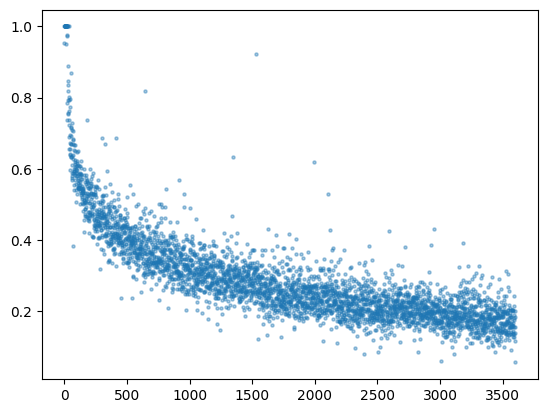

In [7]:
loss_history_tmp = [i if i < 1 else 1 for i in loss_history]
plt.scatter(y=loss_history_tmp, x=range(len(loss_history_tmp)), s=5, alpha=0.4);

/home/sebastiaan/fun/alarso/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


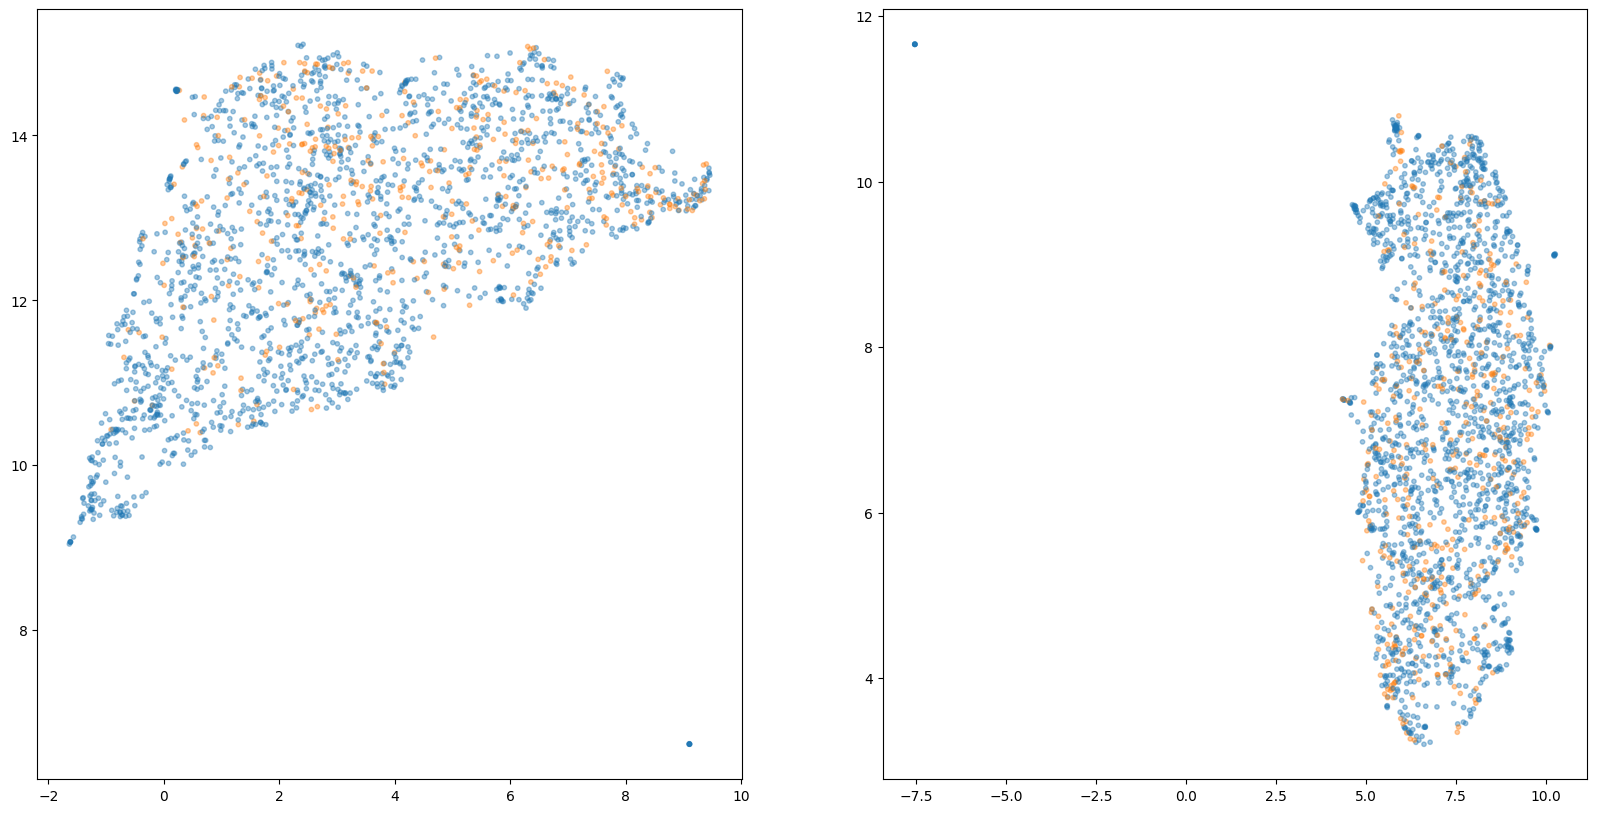

In [8]:
labels = []
embeddings = torch.empty((0, 5*1024)).cuda()
transformed_embeddings = torch.empty((0, 5*1024)).cuda()

model.eval()
for idx, batch in enumerate(loader):
    data = batch[0]
    out = model(data)
    embeddings = torch.vstack((embeddings, data[0].cuda()))
    transformed_embeddings = torch.vstack((transformed_embeddings, out))
    labels.extend(batch[3].cpu().numpy())

red_embeddings = UMAP(n_neighbors=20).fit_transform(embeddings.cpu().detach().numpy())
red_tranformed_embeddings = UMAP(n_neighbors=20).fit_transform(transformed_embeddings.cpu().detach().numpy())
colors = ["tab:blue" if i == 0 else "tab:orange" for i in labels]

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(red_tranformed_embeddings[:, 0], red_tranformed_embeddings[:, 1], s=10, c=colors,
            alpha=0.4)
plt.subplot(1, 2, 2)
plt.scatter(red_embeddings[:, 0], red_embeddings[:, 1], s=10, c=colors,
            alpha=0.4)
plt.show()